# Set up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Clustering

**Introduction: Classification *vs* Clustering**

In [2]:
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

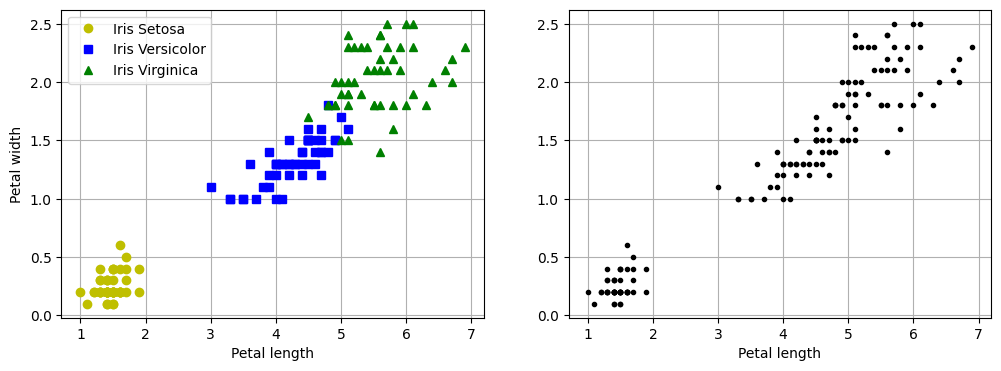

In [3]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(X[:, 2][y == 0], X[:, 3][y == 0], "yo", label="Iris Setosa")
plt.plot(X[:, 2][y == 1], X[:, 3][y == 1], "bs", label="Iris Versicolor")
plt.plot(X[:, 2][y == 2], X[:, 3][y == 2], "g^", label="Iris Virginica")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(X[:, 2], X[:, 3], "k.")
plt.xlabel("Petal length")
plt.grid()

plt.show()

**Note:** The next code cell shows how a Gaussian Mixture model (explained later in this notebook) can actually these clusters quite well using all 4 features: petal length and width, sepal length and width.   

In [4]:
from sklearn.mixture import GaussianMixture

y_predict = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

Next, we map each cluster to a class. Each cluster will have a unique id and here we try to map the cluster's id to the class in the dataset. Instead of hard coding the mapping, we will use `scipy.stats.mode()` function.

In [5]:
from scipy import stats

mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_predict[y == class_id])
    mapping[mode] = class_id

Then we transform the predicted array to use the class in the dataset, instead of its self-created id, and plot the result.

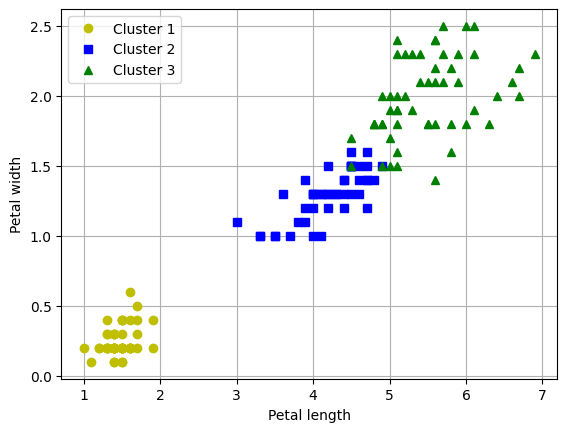

In [6]:
y_predict = np.array([mapping[cluster_id] for cluster_id in y_predict])

plt.plot(X[y_predict == 0, 2], X[y_predict == 0, 3], "yo", label="Cluster 1")
plt.plot(X[y_predict == 1, 2], X[y_predict == 1, 3], "bs", label="Cluster 2")
plt.plot(X[y_predict == 2, 2], X[y_predict == 2, 3], "g^", label="Cluster 3")
plt.grid()
plt.legend()
plt.xlabel("Petal length")
plt.ylabel("Petal width")

plt.show()

What's the ratio of iris plant we assigned to the right cluster?

In [7]:
(y_predict == y).sum() / len(y)

0.9666666666666667

And we only misclassify 5 of them.

In [8]:
len(y) - (y_predict == y).sum()

5

## K-means

**Fit and predict**

Here, we train a K-means clustering algorithm on a dataset of blobs. It will try to find the centroid of each blob and assign each instance to the closet blob.

In [9]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

blob_centers = np.array(
    [[0.2, 2.3], [-1.5, 2.3], [-2.8, 1.8], [-2.8, 2.8], [-2.8, 1.3]]
)
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(
    n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=7
)

Here, `random_state` is set to 1, to ensure that the centroids will be at the blob centers. The detail will be explained further as you go.

In [10]:
k = 5
k_means = KMeans(n_clusters=k, n_init=10, random_state=1)
y_predict = k_means.fit_predict(X)

Then we will plot them.

In [11]:
def plot_cluster(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

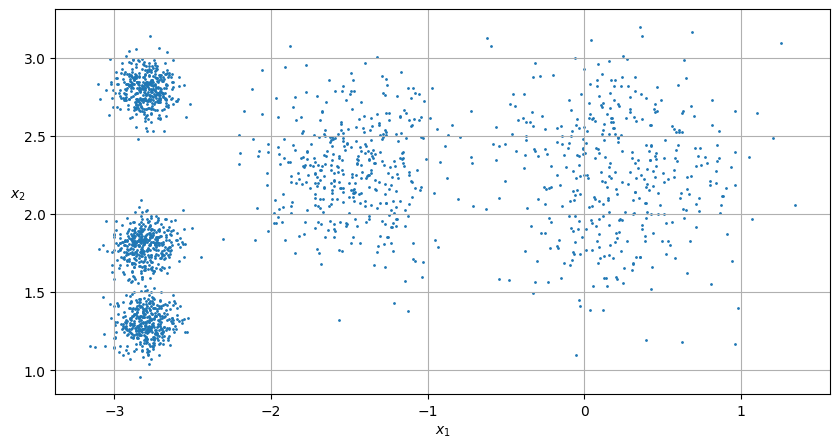

In [12]:
plt.figure(figsize=(10, 5))
plot_cluster(X)
plt.grid()

plt.show()

Each instance is assigned to one of the 5 clusters.

In [13]:
y_predict

array([1, 4, 0, ..., 3, 0, 4], dtype=int32)

In [14]:
y_predict is k_means.labels_

True

The following 5 centroids (i.e. cluster centers) were estimated as:  

In [15]:
k_means.cluster_centers_

array([[ 0.20876306,  2.25551336],
       [-2.80037642,  1.30082566],
       [-1.46679593,  2.28585348],
       [-2.79290307,  2.79641063],
       [-2.80389616,  1.80117999]])

Note that `KMeans` preserves the label of each instance it was trained on. This label is the index of the cluster it belongs to, not to be confused with the labels in the training set. 

In [16]:
k_means.labels_

array([1, 4, 0, ..., 3, 0, 4], dtype=int32)

Of course, we can predict the cluster new instances may belong to. 

In [17]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
k_means.predict(X_new)

array([0, 0, 3, 3], dtype=int32)

**Decision boundaries**

In [18]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], "k.", markersize=2)

In [19]:
def plot_centroids(centroids, weights=None, circle_color="w", cross_color="k"):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="o",
        s=35,
        linewidths=8,
        color=circle_color,
        zorder=10,
        alpha=0.9,
    )
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="x",
        s=2,
        linewidths=12,
        color=cross_color,
        zorder=11,
        alpha=1,
    )

In [20]:
def plot_decision_boundaries(
    clusterer,
    X,
    resolution=1000,
    show_centroids=True,
    show_xlabels=True,
    show_ylabels=True,
):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(
        np.linspace(mins[0], maxs[0], resolution),
        np.linspace(mins[1], maxs[1], resolution),
    )
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel2")
    plt.contour(
        Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors="k"
    )
    plot_data(X)

    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)
    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)

    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

The result is a *Voronoi* diagram.

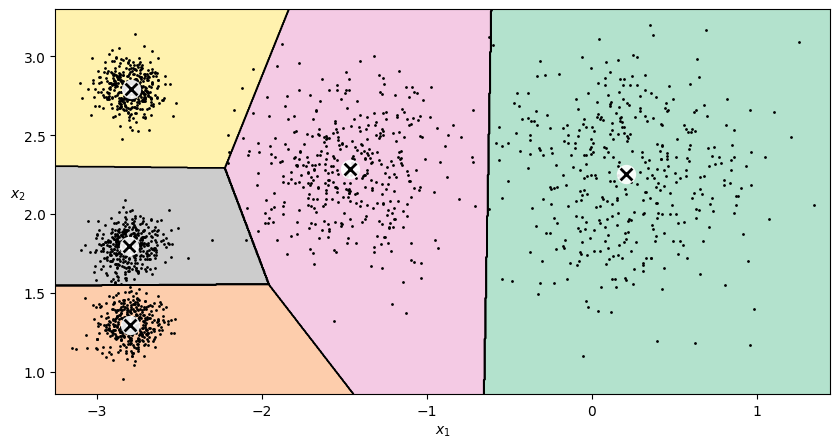

In [21]:
plt.figure(figsize=(10, 5))
plot_decision_boundaries(k_means, X)
plt.show()

Great! Some instances along the edge may be assigned to the wrong cluster, but in general, our model work very good.

**Hard Clustering vs Soft Clustering**

Rather than just assign an instance to the closest cluster, which is called *hard clustering*, it could be better to measure the distance to all 5 centroids. This is what the `transform()` method does.

In [22]:
k_means.transform(X_new).round(2)

array([[0.33, 2.89, 1.49, 2.9 , 2.81],
       [2.8 , 5.84, 4.48, 5.85, 5.81],
       [3.29, 1.71, 1.69, 0.29, 1.21],
       [3.22, 1.22, 1.55, 0.36, 0.73]])

You can check that this is in fact the Euclidean distance between each instance and each centroid.

In [23]:
np.linalg.norm(
    np.tile(X_new, (1, k)).reshape(-1, k, 2) - k_means.cluster_centers_, axis=2
).round(2)

array([[0.33, 2.89, 1.49, 2.9 , 2.81],
       [2.8 , 5.84, 4.48, 5.85, 5.81],
       [3.29, 1.71, 1.69, 0.29, 1.21],
       [3.22, 1.22, 1.55, 0.36, 0.73]])

### The K-Means algorithm

The K-means algorithm is one of the fastest clustering algorithms, and also one of the simplest:
- First, initialize *k* centroids randomly. Which means select k distinct instances randomly from the dataset and places the centroids at their instances' locations.
- Repeat until converges (i.e. until the centroids stop moving):
    - Assign each instances to the closest centroid.
    - Update the centroids to be the mean of all the instances assigned to them.

The `KMeans` class uses an optimized initialization technique by default. To use the original K-Means algorithm (for educational purpose only, as it is subjectively worse than the default one), you must set `init=random` and `n_init=1`. More on that later on this chapter.

Here, we will run the K-means algorithm for 1, 2 and 3 iterations and see how the centroids move around.

In [24]:
k_means_iter1 = KMeans(
    n_clusters=5, init="random", n_init=1, max_iter=1, random_state=1
)
k_means_iter2 = KMeans(
    n_clusters=5, init="random", n_init=1, max_iter=2, random_state=1
)
k_means_iter3 = KMeans(
    n_clusters=5, init="random", n_init=1, max_iter=3, random_state=1
)
k_means_iter1.fit(X)
k_means_iter2.fit(X)
k_means_iter3.fit(X)

KMeans(init='random', max_iter=3, n_clusters=5, n_init=1, random_state=1)

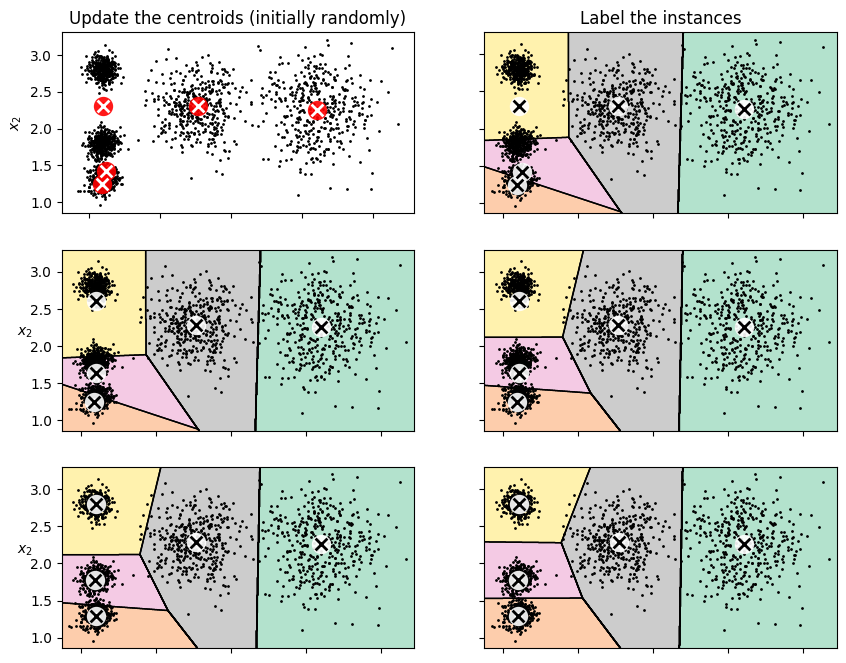

In [25]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(k_means_iter1.cluster_centers_, circle_color="r", cross_color="w")
plt.ylabel("$x_2$")
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)")

plt.subplot(322)
plot_decision_boundaries(k_means_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances")

plt.subplot(323)
plot_decision_boundaries(k_means_iter1, X, show_xlabels=False, show_centroids=False)
plot_centroids(k_means_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(k_means_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(k_means_iter2, X, show_xlabels=False, show_centroids=False)
plot_centroids(k_means_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(k_means_iter3, X, show_xlabels=False, show_ylabels=False)

There is one downside of the original K-means algorithm: If you run K-means multiple times (with different random seeds), each time the model can converge to different solution. That means the model could be a suboptimal solution.

In [31]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(12, 4))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X)
    if title1:
        plt.title(title2)

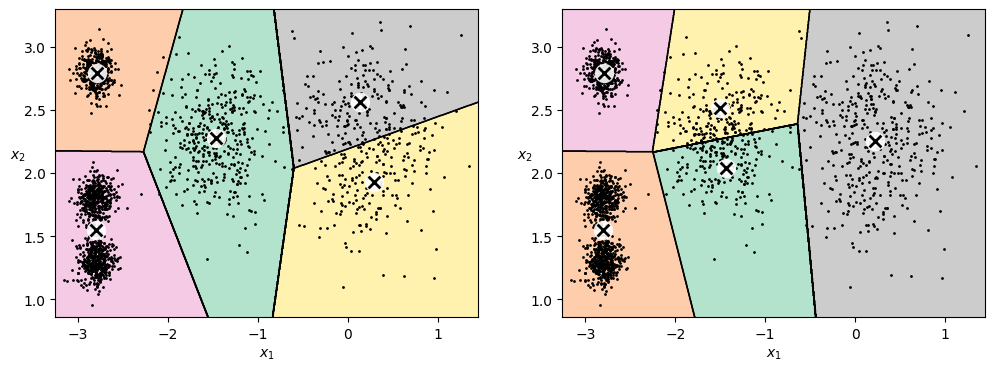

In [39]:
k_means_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1, random_state=2)
k_means_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1, random_state=5)

plot_clusterer_comparison(k_means_rnd_init1, k_means_rnd_init2, X)
plt.show()